📂 Base: /Users/ueharakeiji/Desktop/statec
📂 CSV dir: /Users/ueharakeiji/Desktop/statec/data/census_csv
📂 Files found: ['LU1,DSD_CENSUS_GROUP1_3@DF_B1607,1.0+all.csv', 'LU1,DSD_CENSUS_GROUP7_10@DF_B1626,1.0+all.csv', 'LU1,DSD_CENSUS_GROUP7_10@DF_B1625,1.0+all.csv', 'LU1,DSD_CENSUS_GROUP1_3@DF_B1608,1.0+all.csv', 'LU1,DSD_CENSUS_GROUP1_3@DF_B1609,1.0+all.csv']
✅ All CSV files loaded successfully!
✅ KPI CSV saved: commune_kpi_2021_communes_final.csv (101 communes)


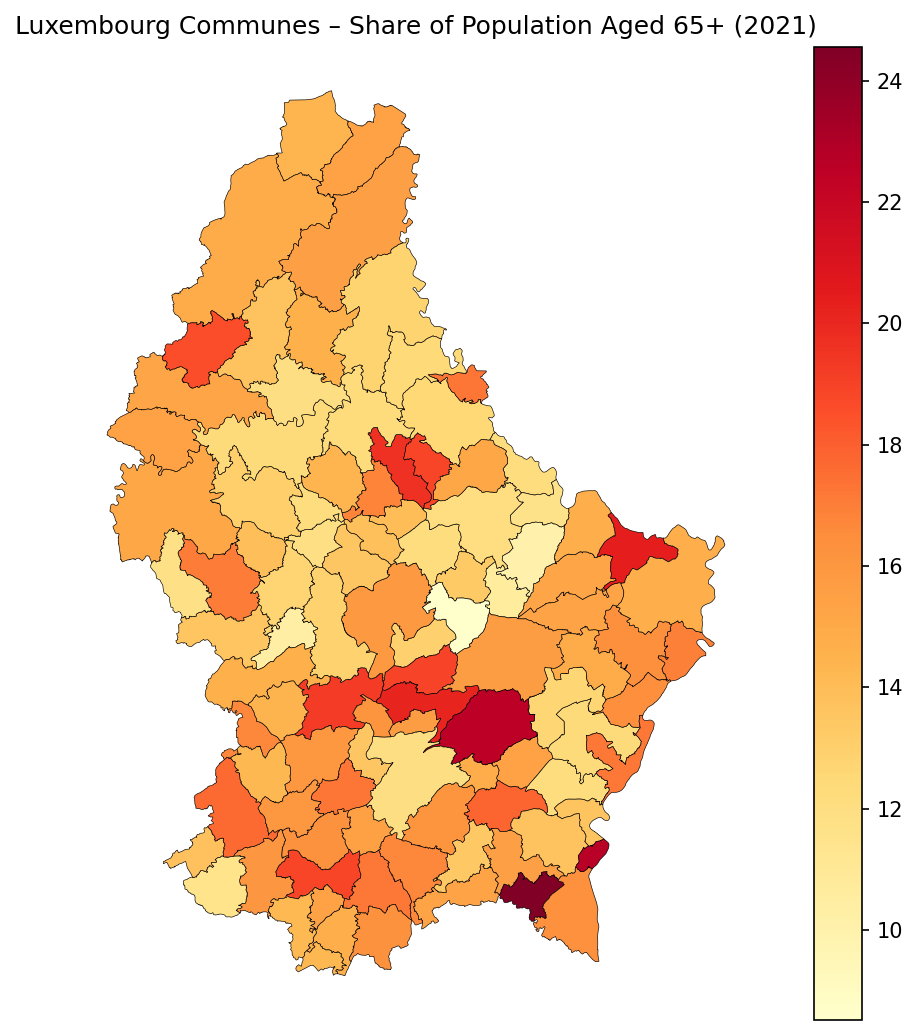

✅ GeoJSON saved: lux_communes_kpi.geojson


In [5]:
# === Luxembourg Census 2021 Commune KPI + Map ===
# Author: Keiji Uehara (STATEC Hackathon)
# Purpose: Build commune-level KPIs and visualize ageing rate by commune
# -------------------------------------------------------------------

import os
os.environ["USE_PYGEOS"] = "0"

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# === 1. パス設定（Jupyter対応）===
try:
    base = Path(__file__).resolve().parents[1]
except NameError:
    base = Path.cwd().parents[0]

data_dir = base / "data"
csv_dir = data_dir / "census_csv"
shape_dir = data_dir / "shapefiles"
output_dir = base / "outputs"
output_dir.mkdir(exist_ok=True)

print(f"📂 Base: {base}")
print(f"📂 CSV dir: {csv_dir}")
print(f"📂 Files found: {[p.name for p in csv_dir.glob('*.csv')]}")

# === 2. データ読み込み ===
def load_csv(name):
    fp = csv_dir / name
    if not fp.exists():
        raise FileNotFoundError(f"❌ {fp} not found")
    return pd.read_csv(fp)

age = load_csv("LU1,DSD_CENSUS_GROUP1_3@DF_B1607,1.0+all.csv")
hh  = load_csv("LU1,DSD_CENSUS_GROUP1_3@DF_B1608,1.0+all.csv")
mar = load_csv("LU1,DSD_CENSUS_GROUP1_3@DF_B1609,1.0+all.csv")
cit = load_csv("LU1,DSD_CENSUS_GROUP7_10@DF_B1625,1.0+all.csv")
cob = load_csv("LU1,DSD_CENSUS_GROUP7_10@DF_B1626,1.0+all.csv")
print("✅ All CSV files loaded successfully!")

# === 3. フィルタ ===
def filter_base(df):
    return df[(df["TIME_PERIOD"] == 2021) & (df["SEX"] == "_T")].copy()

age, hh, mar, cit, cob = map(filter_base, [age, hh, mar, cit, cob])

# === 4. 年齢コード解析 ===
def parse_age(code):
    code = str(code)
    if code == "_T": return (0, 200)
    if code.startswith("Y_LT"): return (0, int(code.replace("Y_LT", "")) - 1)
    if code.startswith("Y_GE"): return (int(code.replace("Y_GE", "")), 200)
    if code.startswith("Y") and "T" in code:
        lo, hi = code[1:].split("T")
        return (int(lo), int(hi))
    return (None, None)

age["age_low"], age["age_high"] = zip(*age["AGE"].map(parse_age))

# === 5. 年齢層別に集計 ===
def sum_by_geo(df, mask):
    return df.loc[mask].groupby("GEO")["OBS_VALUE"].sum()

youth = sum_by_geo(age, (age["age_low"] >= 0) & (age["age_high"] <= 14))
work  = sum_by_geo(age, (age["age_low"] >= 15) & (age["age_high"] <= 64))
old   = sum_by_geo(age, (age["age_low"] >= 65))
pop_total = youth.add(work, fill_value=0).add(old, fill_value=0)

# === 6. KPI構築 ===
kpi = pd.DataFrame({
    "pop_total_2021": pop_total,
    "pop_0_14": youth,
    "pop_15_64": work,
    "pop_65p": old
})
kpi["share_65p"]  = (kpi["pop_65p"] / kpi["pop_total_2021"] * 100)
kpi["old_dep_ratio"]   = (kpi["pop_65p"] / kpi["pop_15_64"] * 100)
kpi["youth_dep_ratio"] = (kpi["pop_0_14"] / kpi["pop_15_64"] * 100)

# === 7. Citizenship / Birth ===
cit_tot = cit[cit["CITIZEN"] == "_T"].groupby("GEO")["OBS_VALUE"].sum()
cit_for = cit[cit["CITIZEN"] == "FOR"].groupby("GEO")["OBS_VALUE"].sum()
cob_tot = cob[cob["Country of birth"] == "Total"].groupby("GEO")["OBS_VALUE"].sum()
cob_for = cob[cob["Country of birth"] == "Foreign"].groupby("GEO")["OBS_VALUE"].sum()

kpi["share_foreign_citizenship"] = (cit_for / cit_tot * 100)
kpi["share_foreign_born"] = (cob_for / cob_tot * 100)

# === 8. Marital / Household ===
mar_tot = mar[mar["LMS"] == "Total"].groupby("GEO")["OBS_VALUE"].sum()
def mar_share(lbl):
    s = mar[mar["LMS"].str.startswith(lbl)].groupby("GEO")["OBS_VALUE"].sum()
    return (s / mar_tot * 100)
kpi["share_never_married"] = mar_share("Never married")
kpi["share_divorced"] = mar_share("Divorced")
kpi["share_widowed"] = mar_share("Widowed")

hh_tot = hh[hh["Household status"] == "Total"].groupby("GEO")["OBS_VALUE"].sum()
hh_notfam = hh[hh["Household status"] == "Persons not in a family nucleus"].groupby("GEO")["OBS_VALUE"].sum()
hh_private = hh[hh["Household status"] == "Persons living in a private household"].groupby("GEO")["OBS_VALUE"].sum()
hh_inst = hh[hh["Household status"] == "Persons in an institutional household"].groupby("GEO")["OBS_VALUE"].sum()

kpi["share_not_in_family_nucleus"] = (hh_notfam / hh_tot * 100)
kpi["share_private_household"] = (hh_private / hh_tot * 100)
kpi["share_institutional"] = (hh_inst / hh_tot * 100)

# === 9. Commune名付与・フィルタ ===
names = age[["GEO", "Geographic level"]].drop_duplicates().set_index("GEO")
kpi = names.join(kpi, how="left").reset_index().rename(columns={"GEO": "LAU", "Geographic level": "commune"})
mask = ~kpi["commune"].str.contains(r"^(?:Canton|District|Grand-Duchy|Luxembourg \(Capitale\)|Grand Duchy)", regex=True, na=False)
kpi = kpi[mask].reset_index(drop=True)

# === 10. LAUコード整形 ===
kpi["LAU_trim"] = kpi["LAU"].astype(str).str.replace("^LU0+", "", regex=True).str.zfill(5)

# === 11. 統合コミューン補正 ===
merge_map = {
    "00711": ["00705", "00710"],  # Grosbous + Wahl
    "01209": ["01201", "01208"],  # Bous + Waldbredimus
}
for new_code, old_codes in merge_map.items():
    subset = kpi[kpi["LAU_trim"].isin(old_codes)]
    if not subset.empty:
        row = subset.iloc[0].copy()
        row["LAU_trim"] = new_code
        for col in ["pop_total_2021", "pop_0_14", "pop_15_64", "pop_65p"]:
            row[col] = subset[col].sum()
        row["share_65p"] = (row["pop_65p"] / row["pop_total_2021"] * 100)
        row["old_dep_ratio"] = (row["pop_65p"] / row["pop_15_64"] * 100)
        row["youth_dep_ratio"] = (row["pop_0_14"] / row["pop_15_64"] * 100)
        kpi = pd.concat([kpi, pd.DataFrame([row])], ignore_index=True)

old_codes = sum(merge_map.values(), [])
kpi = kpi[~kpi["LAU_trim"].isin(old_codes)].reset_index(drop=True)

# === 12. 保存 ===
csv_out = output_dir / "commune_kpi_2021_communes_final.csv"
kpi.to_csv(csv_out, index=False)
print(f"✅ KPI CSV saved: {csv_out.name} ({len(kpi)} communes)")

# === 13. 地図データ結合 ===
gdf = gpd.read_file(shape_dir / "LIMADM_COMMUNES.shp")
gdf["LAU2_str"] = gdf["LAU2"].astype(str).str.zfill(5)
merged = gdf.merge(kpi, left_on="LAU2_str", right_on="LAU_trim", how="left")
merged = merged.to_crs(4326)

# === 14. Choropleth ===
plt.figure(figsize=(8,7), dpi=150)
ax = plt.gca()
merged.plot(column="share_65p", legend=True, cmap="YlOrRd", edgecolor="black", linewidth=0.3, ax=ax)
ax.set_axis_off()
plt.title("Luxembourg Communes – Share of Population Aged 65+ (2021)", fontsize=12)
plt.tight_layout()
plt.show()

# === 15. GeoJSON出力 ===
geojson_out = output_dir / "lux_communes_kpi.geojson"
merged.to_file(geojson_out, driver="GeoJSON")
print(f"✅ GeoJSON saved: {geojson_out.name}")